In [1]:
# Last mod: FA 2023 Mar 14

# Predicting ages from spectroscopic abundances with XGBoost 

This is **not** the main analysis of the paper.
To reproduce the XGBoost run presented in the paper, please go to [./train_xgboost_miglio2021.ipynb](train_xgboost_miglio2021.ipynb).

Here we just perform some additional tests.

## Additional tests for the paper

1. Separate models for RGB and RC
2. Impact of using fewer input columns
3. Run with noise-added data

In [71]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from scipy.stats import gaussian_kde
from scipy.interpolate import make_interp_spline

import os.path

from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

import xgboost as xgb
import shap

from itertools import product
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from utils import running_median, overplot_trend

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 
font = {'family' : 'serif', 'serif': 'helvet', 'weight' : 'bold', 'size'   : 20}
mpl.rc('font', **font)
mpl.rc('text', usetex=True)

In [72]:
suffix = "_230414" # date

### Create the training set

We use the table containing asteroseismic+spectroscopic age estimates from [Miglio et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract) - crossmatched with APOGEE DR17:

In [73]:
miglio2021 = Table.read("../data/Miglio2021_X_APOGEE_DR17.fits")
names = [name for name in miglio2021.colnames if len(miglio2021[name].shape) <= 1]
miglio2021.keep_columns(names)
mig = miglio2021.to_pandas()
# Clean the sample a bit
mig = mig[(mig['RV_FLAG'] == 0)   & (mig['C_FE_FLAG'] == 0)   & \
          (mig['CI_FE_FLAG'] == 0)& (mig['N_FE_FLAG'] == 0)   & \
          (mig['O_FE_FLAG'] == 0) & (mig['NA_FE_FLAG'] == 0)  & \
          (mig['S_FE_FLAG'] == 0) & (mig['TI_FE_FLAG'] == 0)& \
          (mig['V_FE_FLAG'] == 0) & (mig['CE_FE_FLAG'] == 0)  & \
          (mig['SNREV'] >= 70) & \
          (0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"] < 0.3) & \
          (0.5 * (mig['b_age_lc'] - mig['b_Age']) < 3) & \
          (mig["Age"] > 0)    & (mig["Age"] < 15) & \
          (mig["ALPHA_M"] < 0.14 + 0.0001*(mig["Age"] - 4.1)**5)
         ]
print(len(mig), "suffice the FLAG conditions")

# Cut out the relevant columns
trainfeatures = ['TEFF', 'LOGG', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 
                 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'K_FE', 
                 'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'CE_FE']
filtered_df = mig[['Age'] + trainfeatures].copy() # excluding: ['FE_H', ]
filtered_df = filtered_df.dropna()
filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')

# Split dataframe into input and output columns
y = filtered_df['Age']
X = filtered_df.drop(columns = 'Age')

# Splitting into train and test (80% vs 20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

3060 suffice the FLAG conditions


### Run the default XGBoost model:

The hyperparameter optimisation for XGBoost gave us these parameters:

In [74]:
best_params = {'learning_rate': 0.005,
              'max_depth': 7,
              'min_child_weight': 10,
              'n_estimators': 1500,
              'nthread': 4,
              'objective': 'reg:squarederror',
              'subsample': 0.6}

In [75]:
filename = './models/default_model_'+suffix+'.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(**best_params, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.064779
Score: 0.8763141916547467


# 1. Separate models for RGB and RC

In [76]:
# Define a function that does the magic:

def xgboost(filtered_df):
    # Split dataframe into input and output columns
    y = filtered_df['Age']
    X = filtered_df.drop(columns = 'Age')
    
    # Splitting into train and test
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                          test_size = 0.2, random_state = 123)
      
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 700, learning_rate = 0.01,
                             max_depth = 6, min_child_weight = 6, 
                             subsample = 0.6, seed = 123)    
    model.fit(train_X, train_y)
    pred = model.predict(test_X)
    return model, test_y, pred

In [77]:
# Consider fitting RGBs and RCs separately:
rgbs = filtered_df[mig["evstate"]==1]
rcs  = filtered_df[mig["evstate"]==2]
model_rgb, test_rgb, pred_rgb = xgboost(rgbs)
model_rc,  test_rc,  pred_rc  = xgboost(rcs)
# Save these models:
pickle.dump(model_rgb, open('./models/rgb_model.pkl', 'wb'))
pickle.dump(model_rc,  open('./models/rc_model.pkl',  'wb'))

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


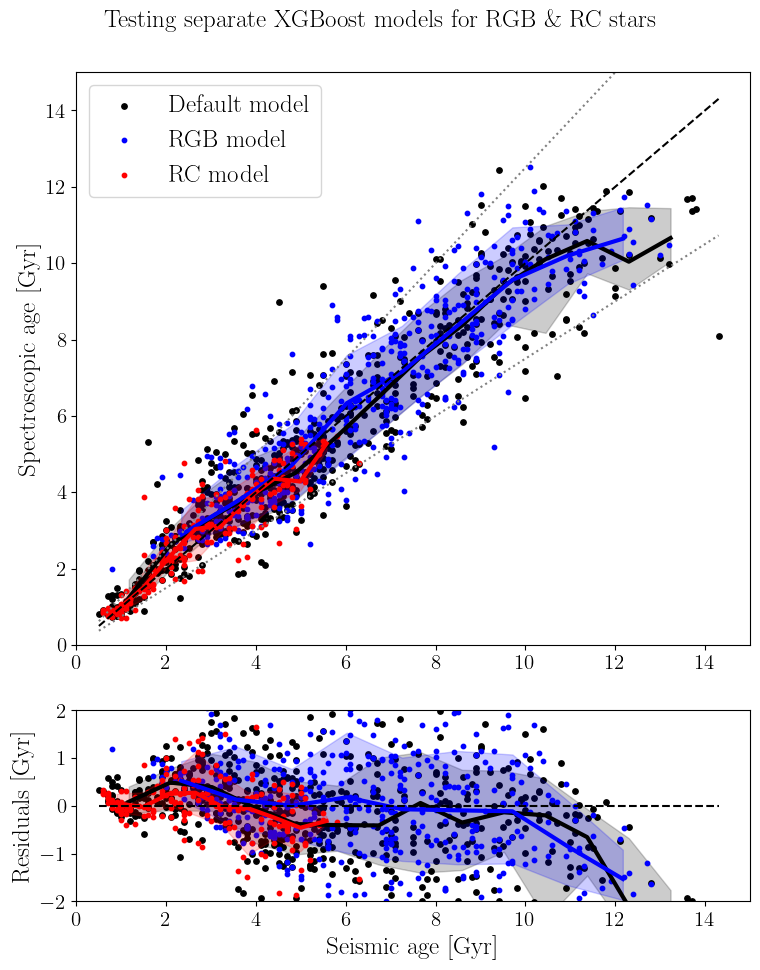

In [79]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(8,10))

plot_rgb_rc = True

# Top panel: predicted age vs. seismic age
plt.axes(a0)
a0.scatter(test_y, pred, c="k", s=15, label="Default model")
overplot_trend(test_y, pred, alpha=0.2, color="k", bins=15)
if plot_rgb_rc:
    a0.scatter(test_rgb, pred_rgb, c="b", s=10, label="RGB model")
    overplot_trend(test_rgb, pred_rgb, alpha=0.2, color="b", bins=10)
    a0.scatter(test_rc,  pred_rc, c="r", s=10, label="RC model")
    overplot_trend(test_rc,  pred_rc, alpha=0.2, color="r", bins=10)
xx = np.linspace(np.min(test_y), np.max(test_y), 20)
a0.plot(xx, xx, color = 'k', ls="dashed")
a0.plot(xx, 1.25*xx, color = 'grey', ls="dotted")
a0.plot(xx, 0.75*xx, color = 'grey', ls="dotted")
a0.set_ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
a0.legend(loc="upper left", fontsize=18)
a0.axis([0,15,0,15])

# Bottom panel: residuals
plt.axes(a1)
a1.scatter(test_y, pred-test_y, c="k", s=15)
overplot_trend(test_y, pred-test_y, alpha=0.2, color="k", bins=15)
if plot_rgb_rc:
    a1.scatter(test_rgb, pred_rgb-test_rgb, c="b", s=10)
    overplot_trend(test_rgb, pred_rgb-test_rgb, alpha=0.2, color="b", bins=10)
    a1.scatter(test_rc,  pred_rc-test_rc, c="r", s=10)
    overplot_trend(test_rc, pred_rc-test_rc, alpha=0.2, color="r", bins=10)
a1.plot(xx, np.zeros(len(xx)), color = 'k', ls="dashed")
a1.set_xlabel(r"Seismic age [Gyr]", fontsize=18)
a1.set_ylabel(r"Residuals [Gyr]", fontsize=18)

a1.axis([0,15,-2, 2])
plt.suptitle(r"Testing separate XGBoost models for RGB \& RC stars", fontsize=18)
plt.tight_layout()
plt.savefig("../im/predicted_vs_true_testdata_rgb_rc.png", dpi=300)

# 2. Model with reduced number of columns

In [80]:
trainfeatures2 = ['TEFF', 'LOGG', 'C_FE', 'N_FE', 'MG_FE']
filtered_df2 = mig[['Age'] + trainfeatures2].copy() # excluding: ['FE_H', 'CE_FE']
filtered_df2 = filtered_df2.dropna()
filtered_df2 = filtered_df2.apply(pd.to_numeric, errors='coerce')
# Split dataframe into input and output columns
y2 = filtered_df2['Age']
X2 = filtered_df2.drop(columns = 'Age')
# Splitting into train and test (80% vs 20%)
train_X2, test_X2, train_y2, test_y2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)
# Grid search: commented out for speed
"""
parameters = {
    'nthread':[4],
    'objective':['reg:squarederror'],
    'learning_rate':[0.002, 0.005, 0.01],
    'max_depth':[6, 7, 8],
    'min_child_weight': [8, 10, 12],
    'subsample':[0.6],
    'n_estimators':[1000, 1500, 2000]
}
xgb_grid2 = GridSearchCV(xgb1, parameters, cv=2, n_jobs=2, verbose=True)
xgb_grid2.fit(train_X2, train_y2)
xgb_grid2.best_params_
"""

Fitting 2 folds for each of 216 candidates, totalling 432 fits


{'learning_rate': 0.005,
 'max_depth': 6,
 'min_child_weight': 8,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'reg:squarederror',
 'subsample': 0.6}

In [81]:
best_params2 = {'learning_rate': 0.005, 
                'max_depth': 6, 
                'min_child_weight': 8, 
                'n_estimators': 1000, 
                'nthread': 4,
                'objective': 'reg:squarederror', 
                'subsample': 0.6}

filename2 = './models/model_5params_'+suffix+'.pkl'

if os.path.exists(filename2):
    # Read the trained model from disk:
    model2 = pickle.load(open(filename2, 'rb'))
else:
    # Instantiation
    model2 = xgb.XGBRegressor(**best_params2, seed = 123)
    # Fit the model
    model2.fit(train_X2, train_y2)
    # Save the model
    pickle.dump(model2, open(filename2, 'wb'))

# Predict the model
pred2 = model2.predict(test_X2)
  
# RMSE Computation
rmse2 = np.sqrt(MSE(test_y2, pred2))
print("RMSE : % f" %(rmse2))

#Score
result2 = model2.score(test_X2, test_y2)
print("Score: "+str(result2))

RMSE :  1.163097
Score: 0.8596338781830857


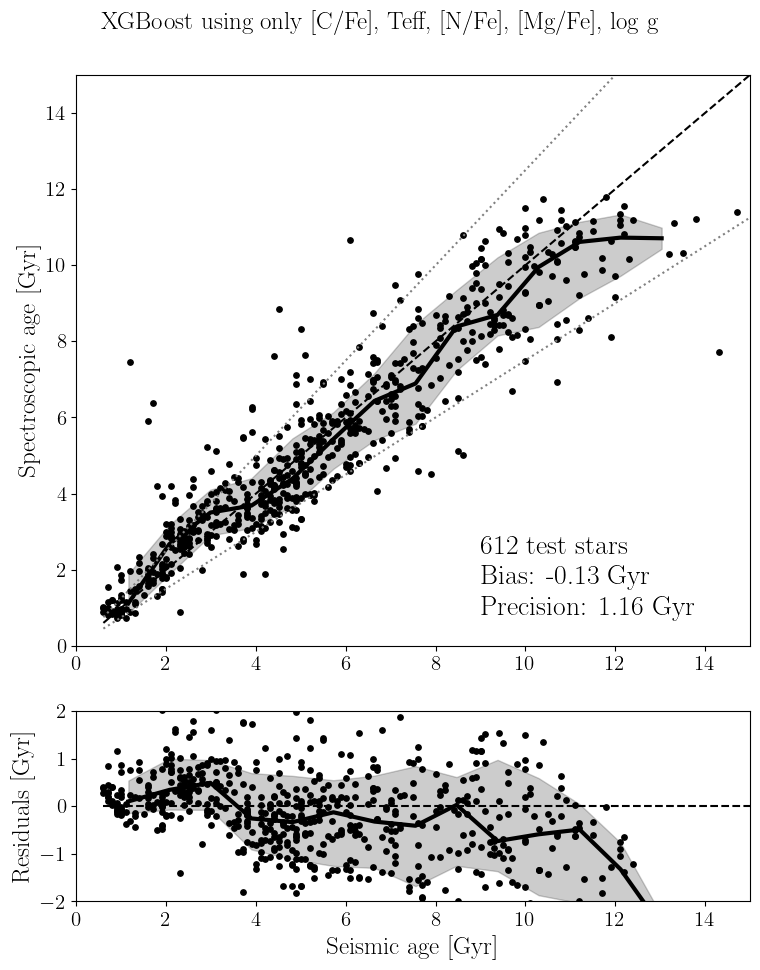

In [87]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(8,10))

plot_rgb_rc = False

# Top panel: predicted age vs. seismic age
plt.axes(a0)
a0.scatter(test_y2, pred2, c="k", s=15, label="")
overplot_trend(test_y2, pred2, alpha=0.2, color="k", bins=15)
xx = np.linspace(np.min(test_y2), 15, 20)
a0.plot(xx, xx, color = 'k', ls="dashed")
a0.plot(xx, 1.25*xx, color = 'grey', ls="dotted")
a0.plot(xx, 0.75*xx, color = 'grey', ls="dotted")
a0.set_ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
#a0.legend(loc="upper left", fontsize=18)
a0.axis([0,15,0,15])
plt.text(9, 2.4, str(len(test_y2))+ " test stars", fontsize=20)
plt.text(9, 1.6, "Bias: "+ str(np.round(np.mean(pred2-test_y2),2))+ " Gyr", fontsize=20)
plt.text(9, 0.8, "Precision: "+ str(np.round(np.std(pred2-test_y2),2))+ " Gyr", fontsize=20)

# Bottom panel: residuals
plt.axes(a1)
a1.scatter(test_y2, pred2-test_y2, c="k", s=15)
overplot_trend(test_y2, pred2-test_y2, alpha=0.2, color="k", bins=15)
a1.plot(xx, np.zeros(len(xx)), color = 'k', ls="dashed")
a1.set_xlabel(r"Seismic age [Gyr]", fontsize=18)
a1.set_ylabel(r"Residuals [Gyr]", fontsize=18)

a1.axis([0,15,-2, 2])
plt.suptitle(r"XGBoost using only {[C/Fe], Teff, [N/Fe], [Mg/Fe], log g}", fontsize=18)
plt.tight_layout()
plt.savefig("../im/predicted_vs_true_testdata_5params.png", dpi=300)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


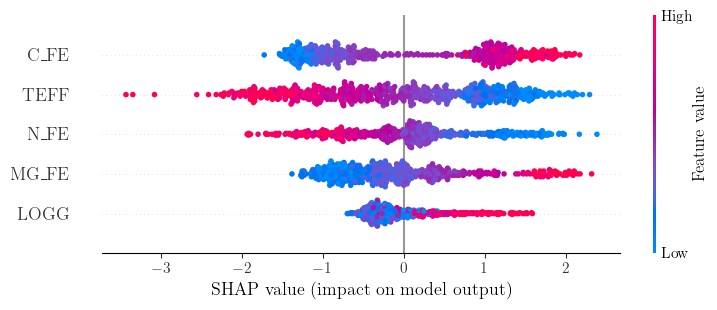

In [85]:
# Fits the explainer
explainer2 = shap.Explainer(model2)
# Calculates the SHAP values - It might take some time
shap_values2 = explainer2(test_X2)
shap.summary_plot(shap_values2, test_X2, show=False)
# Same as
#shap.plots.beeswarm(shap_values)
plt.savefig("../im/shap_beeswarm_5params.png", dpi=300)

# XGBOOST WITH PERTURBED DATA